In [1]:
from astropy.io import fits
import numpy as np
import pandas as pd

In [3]:
planck = pd.DataFrame([])
with fits.open('./Planck_SZ2.fits') as table:
    data = table[1].data
    keys = data.names
    saved_keys = ['Name', 'RAdeg', 'DEdeg', 'z', 'MSZ','MCXC', 'RedMAPPer']
    for key in saved_keys:
        planck[key] = data[key]

In [4]:
planck.head()

,Name,RAdeg,DEdeg,z,MSZ,MCXC,RedMAPPer
0,PSZ2 G000.04+45.13,229.190512,-1.017222,0.1198,3.962411,J1516.5-0056,RMJ151653.9-010506.3
1,PSZ2 G000.13+78.04,203.558683,20.255990,0.1710,5.122391,J1334.1+2013,RMJ133408.7+201453.0
2,PSZ2 G000.40-41.86,316.084485,-41.354169,0.1651,5.297053,J2104.3-4120,
3,PSZ2 G000.77-35.69,307.972844,-40.598725,0.3416,6.333562,J2031.8-4037,
4,PSZ2 G002.04-22.15,291.359610,-36.517944,-1.0000,0.000000,,


In [5]:
planck.shape

(1653, 7)

In [9]:
mcxc = pd.DataFrame([])
with fits.open('./MCXC.fits') as table:
    data = table[1].data
    keys = data.names
    print(keys)
    saved_keys = ['MCXC','RAdeg', 'DEdeg', 'z', 'M500']
    for key in saved_keys:
        mcxc[key] = data[key]

['MCXC', 'OName', 'AName', 'RAh', 'RAm', 'RAs', 'DE-', 'DEd', 'DEm', 'DEs', 'RAdeg', 'DEdeg', 'GLON', 'GLAT', 'z', 'Cat', 'Sub-Cat', 'Scale', 'L500', 'M500', 'R500', 'Notes', 'Cat1', 'Cat2', 'Cat3', 'Cat4', 'L500r1', 'L500r2', 'L500r3', 'L500r4']


In [10]:
mcxc.head()

,MCXC,RAdeg,DEdeg,z,M500
0,J0000.1+0816,0.030,8.274,0.0396,0.7373
1,J0000.4-0237,0.103,-2.625,0.0379,0.3297
2,J0001.6-1540,0.412,-15.681,0.1246,1.6557
3,J0001.9+1204,0.488,12.073,0.2033,2.6927
4,J0003.1-0605,0.799,-6.086,0.2320,5.2188


In [11]:
mcxc.shape

(1743, 5)

In [33]:
redmapper_ = pd.DataFrame([])
with fits.open('./redmapper_dr8_public_v6.3_catalog.fits') as table:
    data = table[1].data
    keys = data.names
    print(keys)
    saved_keys = ['NAME', 'RA', 'DEC', 'LAMBDA','Z_SPEC']
    for key in saved_keys:
        redmapper_[key] = data[key]

['ID', 'NAME', 'RA', 'DEC', 'Z_LAMBDA', 'Z_LAMBDA_ERR', 'LAMBDA', 'LAMBDA_ERR', 'S', 'Z_SPEC', 'OBJID', 'IMAG', 'IMAG_ERR', 'MODEL_MAG_U', 'MODEL_MAGERR_U', 'MODEL_MAG_G', 'MODEL_MAGERR_G', 'MODEL_MAG_R', 'MODEL_MAGERR_R', 'MODEL_MAG_I', 'MODEL_MAGERR_I', 'MODEL_MAG_Z', 'MODEL_MAGERR_Z', 'ILUM', 'P_CEN', 'RA_CEN', 'DEC_CEN', 'ID_CEN', 'PZBINS', 'PZ']


In [34]:
inter = redmapper_['NAME'].isin(set(redmapper_['NAME']).intersection(set(planck['RedMAPPer'])))
r_inter_p = redmapper_[inter]

In [35]:
r_inter_p.shape

(300, 5)

In [14]:
redmapper.head()

,NAME,RA,DEC,LAMBDA,Z_SPEC
0,RMJ155820.0+271400.3,239.583329,27.233413,169.837845,0.090807
1,RMJ164019.8+464241.5,250.082548,46.711531,199.539276,-1.000000
2,RMJ131129.5-012028.0,197.872957,-1.341116,164.712173,-1.000000
3,RMJ090912.2+105824.9,137.300745,10.973595,174.704178,-1.000000
4,RMJ133520.1+410004.1,203.833723,41.001146,189.181152,0.228309


In [15]:
redmapper.shape

(26111, 5)

In [17]:
filter_mcxc_no_p = mcxc['MCXC'].isin(set(mcxc['MCXC']).difference(set(planck['MCXC'])))
mcxc = mcxc[filter_mcxc_no_p]
mcxc.shape

(1193, 5)

In [18]:
filter_redmapper_no_p = redmapper['NAME'].isin(set(redmapper['NAME']).difference(set(planck['RedMAPPer'])))
redmapper = redmapper[filter_redmapper_no_p]
redmapper.shape

(25811, 5)

In [19]:
redmapper['dist'] = None
redmapper.head()

,NAME,RA,DEC,LAMBDA,Z_SPEC,dist
7,RMJ100214.1+203216.6,150.558906,20.537949,151.364075,0.319619,None
11,RMJ004629.3+202804.8,11.622200,20.468013,123.355934,-1.000000,None
16,RMJ092030.0+302946.8,140.125081,30.496347,38.690826,-1.000000,None
18,RMJ092052.5+302740.3,140.218892,30.461187,128.649414,0.292902,None
19,RMJ133359.1+201801.3,203.496397,20.300356,26.471594,0.176180,None


In [20]:
def ra_dec_distance(ra, dec, ra1, dec1):
    import numpy as np
    from astropy import units as u
    from astropy.coordinates import SkyCoord
    c1 = SkyCoord(ra=ra, dec=dec, unit='deg')
    c2 = SkyCoord(ra=ra1, dec=dec1, unit='deg')
    sep = c1.separation(c2)
    return sep.degree

In [29]:
redmapper = redmapper.reset_index(drop=True)
redmapper.loc[0,'dist'] = 4
redmapper.head()

,NAME,RA,DEC,LAMBDA,Z_SPEC,dist
0,RMJ100214.1+203216.6,150.558906,20.537949,151.364075,0.319619,4
1,RMJ004629.3+202804.8,11.622200,20.468013,123.355934,-1.000000,None
2,RMJ092030.0+302946.8,140.125081,30.496347,38.690826,-1.000000,None
3,RMJ092052.5+302740.3,140.218892,30.461187,128.649414,0.292902,None
4,RMJ133359.1+201801.3,203.496397,20.300356,26.471594,0.176180,None


In [30]:
for i in range(redmapper.shape[0]):
    d = ra_dec_distance(redmapper.iloc[i]['RA'], redmapper.iloc[i]['DEC'], 
                       mcxc['RAdeg'], mcxc['DEdeg'])
    redmapper.loc[i, 'dist'] = min(d)

In [31]:
redmapper.to_csv('./redmapper_w_dists.csv')

In [32]:
redmapper.head()

,NAME,RA,DEC,LAMBDA,Z_SPEC,dist
0,RMJ100214.1+203216.6,150.558906,20.537949,151.364075,0.319619,1.94268
1,RMJ004629.3+202804.8,11.622200,20.468013,123.355934,-1.000000,1.44968
2,RMJ092030.0+302946.8,140.125081,30.496347,38.690826,-1.000000,3.26683
3,RMJ092052.5+302740.3,140.218892,30.461187,128.649414,0.292902,3.30637
4,RMJ133359.1+201801.3,203.496397,20.300356,26.471594,0.176180,2.2222


In [36]:
r_inter_p['dist'] = None
r_inter_p = r_inter_p.reset_index()
for i in range(r_inter_p.shape[0]):
    d = ra_dec_distance(r_inter_p.iloc[i]['RA'], r_inter_p.iloc[i]['DEC'], 
                       planck['RAdeg'], planck['DEdeg'])
    r_inter_p.loc[i, 'dist'] = min(d)

/home/rt2122/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [37]:
r_inter_p.head()

,index,NAME,RA,DEC,LAMBDA,Z_SPEC,dist
0,0,RMJ155820.0+271400.3,239.583329,27.233413,169.837845,0.090807,0.0260783
1,1,RMJ164019.8+464241.5,250.082548,46.711531,199.539276,-1.000000,0.00804658
2,2,RMJ131129.5-012028.0,197.872957,-1.341116,164.712173,-1.000000,0.0134923
3,3,RMJ090912.2+105824.9,137.300745,10.973595,174.704178,-1.000000,0.0170277
4,4,RMJ133520.1+410004.1,203.833723,41.001146,189.181152,0.228309,0.0244114


In [38]:
r_inter_p['dist'].min()

0.0012781551389953582

In [39]:
def histogram(data, n_bins = 0):
    import matplotlib.pyplot as plt
    max_nbins = 10
    data_range = [min(data), max(data)]
    bins = n_bins

    _, ax = plt.subplots()
    ax.hist(data, bins = bins, alpha = 1, label = "")
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_title("")
    ax.legend(loc = 'best')

No handles with labels found to put in legend.


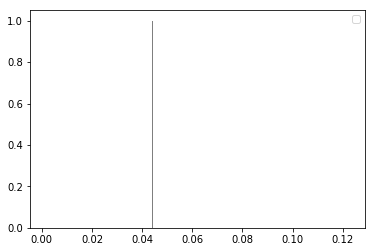

In [41]:
histogram(np.array(r_inter_p['dist']), 100)

In [44]:
r_inter_p['dist'].min(), r_inter_p['dist'].max()

(0.0012781551389953582, 0.1228716082870888)

In [45]:
redmapper.head()

,NAME,RA,DEC,LAMBDA,Z_SPEC,dist
0,RMJ100214.1+203216.6,150.558906,20.537949,151.364075,0.319619,1.94268
1,RMJ004629.3+202804.8,11.622200,20.468013,123.355934,-1.000000,1.44968
2,RMJ092030.0+302946.8,140.125081,30.496347,38.690826,-1.000000,3.26683
3,RMJ092052.5+302740.3,140.218892,30.461187,128.649414,0.292902,3.30637
4,RMJ133359.1+201801.3,203.496397,20.300356,26.471594,0.176180,2.2222


In [87]:
14956 - redmapper[redmapper['dist'] > 0.305][redmapper['LAMBDA'] > 30].shape[0]

/home/rt2122/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


-9